In [9]:
#dependencies
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Dense, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint
import tarfile

In [3]:
#dataset
data_comp = tarfile.open("fer2013.tar") 
ds = pd.read_csv(data_comp.extractfile("fer2013/fer2013.csv"))
ds.head()
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
ds["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
train = ds[["emotion", "pixels"]][ds["Usage"] == "Training"]
train['pixels'] = train['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
train_pix = np.vstack(train['pixels'].values)
test = ds[["emotion", "pixels"]][ds["Usage"] == "PublicTest"]
test['pixels'] = test['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
test_pix = np.vstack(test['pixels'].values)
train_pix.shape, test_pix.shape

((28709, 2304), (3589, 2304))

In [6]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
#0=angry, 1=disgust+fear+surprise, 3=Happy, 4=sad, 6= neutral
#apending 2 and 5 to 1; 5 to 2; 6 to 4
#:::: set append = false to avoid changes
def e_ind(x):
    if(x==2 or x==5):
        return 1
    elif(x==5):
        return 2
    elif(x==6):
        return 4
    else:
        return x
F_S_D = True
if(F_S_D):
    train['emotion'] = train['emotion'].apply(lambda x: e_ind(x))
    test['emotion'] = test['emotion'].apply(lambda x: e_ind(x))
train_ind = np.array(train["emotion"])
test_ind = np.array(test["emotion"])
train_ind.shape, test_ind.shape

((28709,), (3589,))

In [7]:
train_pix = train_pix.reshape(-1,48,48,1)
train_ind = np_utils.to_categorical(train_ind)
test_pix = test_pix.reshape(-1,48,48,1)
test_ind = np_utils.to_categorical(test_ind)
train_ind.shape, test_ind.shape
#train_pix.shape, test_pix.shape

((28709, 5), (3589, 5))

In [17]:
model = Sequential()
model.add(Conv2D(64, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 4))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

if(F_S_D):
    model.add(Dense(5))
else:
    model.add(Dense(7))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization_22 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_43 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 41, 41, 64)        65600     
_________________________________________________________________
batch_normalization_23 (Batc (None, 41, 41, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 41, 41, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 64)        0         
__________

In [18]:
# checkpoint
checkPoint = ModelCheckpoint(filepath='chkPt1.h5', verbose=1, save_best_only=True)

res = model.fit(train_pix, train_ind, epochs=16,
                 shuffle=True,
                 batch_size=100, 
                 validation_data=(test_pix, test_ind),
                 callbacks=[checkPoint], 
                 verbose=2)

# save model to json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/16

Epoch 00001: val_loss improved from inf to 1.18156, saving model to chkPt1.h5
 - 1189s - loss: 1.3142 - acc: 0.4424 - val_loss: 1.1816 - val_acc: 0.4684
Epoch 2/16

Epoch 00002: val_loss improved from 1.18156 to 1.02509, saving model to chkPt1.h5
 - 1089s - loss: 1.1040 - acc: 0.5325 - val_loss: 1.0251 - val_acc: 0.5837
Epoch 3/16

Epoch 00003: val_loss improved from 1.02509 to 0.95903, saving model to chkPt1.h5
 - 1154s - loss: 1.0263 - acc: 0.5712 - val_loss: 0.9590 - val_acc: 0.6144
Epoch 4/16

Epoch 00004: val_loss did not improve
 - 1119s - loss: 0.9729 - acc: 0.5935 - val_loss: 0.9751 - val_acc: 0.5979
Epoch 5/16

Epoch 00005: val_loss improved from 0.95903 to 0.90675, saving model to chkPt1.h5
 - 2065s - loss: 0.9350 - acc: 0.6130 - val_loss: 0.9067 - val_acc: 0.6364
Epoch 6/16

Epoch 00006: val_loss improved from 0.90675 to 0.89092, saving model to chkPt1.h5
 - 1171s - loss: 0.9102 - acc: 0.6239 - val_loss: 0.8909 - v

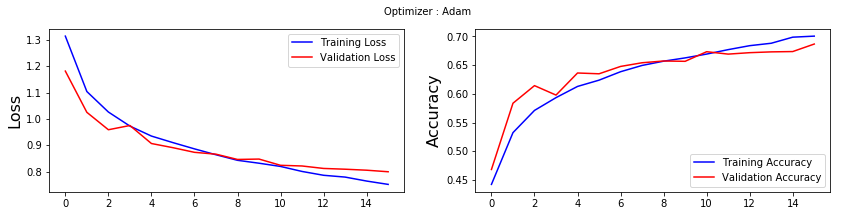

In [19]:
import seaborn as sns
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(res.history['loss'], color='b', label='Training Loss')
plt.plot(res.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(res.history['acc'], color='b', label='Training Accuracy')
plt.plot(res.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [20]:
score = model.evaluate(test_pix, test_ind, verbose=0)
score

[0.79961926936605043, 0.68682084146001676]

In [ ]:
from keras.models import model_from_json
import numpy as np

class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry", "Disgust/fear/surprise","Sad","Happy", "Neutral"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        print("Model loaded from disk")
        self.loaded_model.summary()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)

        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


if __name__ == '__main__':
    pass

In [27]:
import cv2
import numpy as np

rgb = cv2.VideoCapture(0)
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
font = cv2.FONT_HERSHEY_SIMPLEX

def __get_data__():
    _, fr = rgb.read()
    gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    faces = facec.detectMultiScale(gray, 1.3, 5)
    return faces, fr, gray

def start_app(cnn):
    skip_frame = 10
    data = []
    flag = False
    ix = 0
    while True:
        ix += 1
        
        faces, fr, gray_fr = __get_data__()
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            
            roi = cv2.resize(fc, (48, 48))
            pred = cnn.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        if cv2.waitKey(1) == 27:
            break
        cv2.imshow('Filter', fr)
    cv2.destroyAllWindows()


if __name__ == '__main__':
    model = FacialExpressionModel("model1.json", "chkPt1.h5")
    start_app(model)

Model loaded from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization_22 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_43 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 41, 41, 64)        65600     
_________________________________________________________________
batch_normalization_23 (Batc (None, 41, 41, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 41, 41, 64)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 64)      